In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
# import pickle

In [2]:
from simple_veloce_reduction import veloce_path, veloce_reduction_tools

### Set up
It is done outside of my extraction function

In [3]:
run = "CSV_Run"
date = '230826'
arm = 'green'
filename = '26aug20146.fits'
target = 'HD20203-USQ01'

##### Directory structure <br>
It helps me pass all the paths between compnents but is less relevant in this step-by-step deminstration.<br>
I'm not quite happy of my approach to it but I hope it works.

In [4]:
veloce_paths = veloce_path.VelocePaths(run)
veloce_paths.__post_init__()

In [5]:
output_path=os.path.join(os.getcwd(), 'Data', 'Extracted', 'Step-by-step') 
if not os.path.exists(output_path):
    os.makedirs(output_path)

### Begining of data extraction

All below happens in the extraction function:
```
simple_veloce_reduction.extract_run_no_blaze(obs_list_filename, run, arm, veloce_paths=None, output_path=None)
```


In [6]:
# select correct dir name based on arm
if arm == 'green':
    ccd = 'ccd_2'
elif arm == 'red':
    ccd = 'ccd_3'
else:
    raise ValueError('Unsupported arm')

First I load some data that is used across all the files being reduced:

In [7]:
# load wave calibration based on ThAr (from Chris Tinny)
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_ThAr(
                                                                    arm=arm, wave_path=veloce_paths.wave_dir)    

Traces are ones that I extracted from the flats during the first run, they worked fine for data taken in later runs.

In [8]:
# load traces
trace_data = np.load(os.path.join(veloce_paths.trace_dir, f'veloce_trace_{arm}.npz'))
traces, summing_ranges = trace_data['traces'], trace_data['summing_ranges']

Summing ranges are also derived from flats based on flux level above threshold which I dynamically set up for each order. <br>
Later tests showed that these need to be adujusted so the flux goes to zero to minimise noise. <br>
There is no reason to keep it like this in the final product, created an issue on github.

In [9]:
# adjust summing ranges 
### TODO: take a close look at this summing ranges and prepare files that aren't modified?
### remember that traces can change between runs/nights if someone was fiddling with spectrograph
if arm == 'green':
    summing_ranges_mod = np.array([[27,27] for _ in range(len(summing_ranges))])
elif arm == 'red':
    summing_ranges_mod = np.array([[31,31] for _ in range(len(summing_ranges))])
else:
    raise ValueError('Unsupported arm')

In [10]:
# load spectrum
spectrum_filename =  os.path.join(veloce_paths.raw_parent_dir, run, date, ccd, filename)

In [11]:
# I do use "with fits.open() as hdul:" in the actual code to avoid leaving files open
# but to break the flow to steps I'm using simple .open() here
hdul = fits.open(spectrum_filename)
image_data = hdul[0].data
hdr = hdul[0].header

removing overscan bias and merging the four quadrants.<br>
The gain(?) levels between quadrants doesn't seem to match. We spoke once about possible solution with Duncan.

In [12]:
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32)

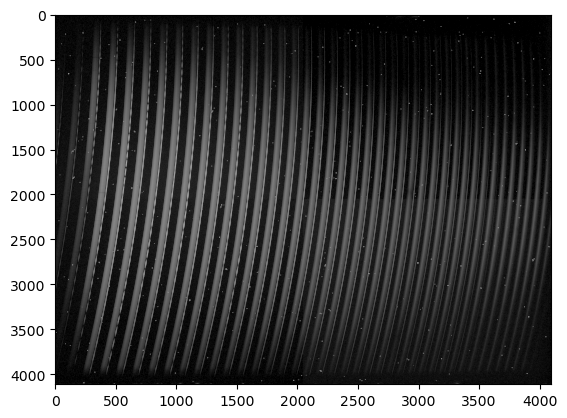

In [13]:
plt.imshow(image_subtracted_bias, aspect='auto', cmap='gray', norm='log')

Extracting orders based on the loaded traces.<br>
Below is a plot from my examination tool presenting cross section of extracted order. The extracted data is sum of counts from region between dashed lines (exclusive). I'm not ploting anything during bulk reduction.

In [14]:
extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
        image_subtracted_bias, traces, summing_ranges_mod, remove_background=False)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  2.,  7., ...,  2.,  1.,  1.],
       [ 4.,  0.,  2., ...,  8.,  0.,  0.],
       ...,
       [ 0.,  2.,  4., ..., 24., 29., 16.],
       [ 0.,  8.,  0., ..., 21., 23., 15.],
       [ 0.,  0.,  8., ...,  4.,  0.,  0.]])

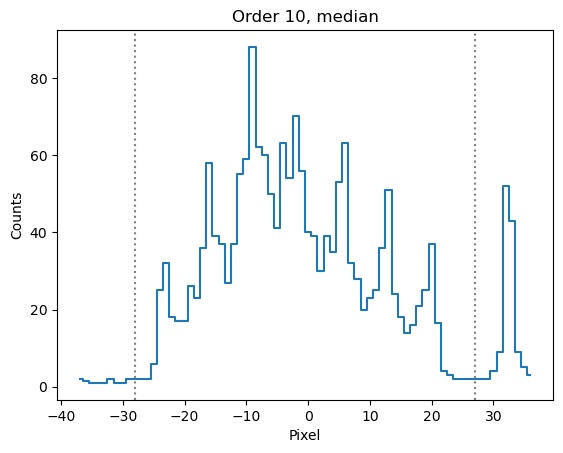

In [15]:
order = 10
veloce_reduction_tools.plot_order_cross_section(image_subtracted_bias, traces, summing_ranges_mod[order], order)

Wave calibration based on the precomputed solution from Chris. There is one order offset between my traces and wave solutions (it is incomplete order and should be removed from traces for final version).

In [16]:
### green part needs shift by one order - issue with labeling?
if arm == 'green':
    final_wave = np.array(veloce_reduction_tools.calibrate_orders_to_wave(
        extracted_science_orders[1:], Y0[0], COEFFS))
    final_flux = np.array(extracted_science_orders[1:])
else:
    final_wave = np.array(veloce_reduction_tools.calibrate_orders_to_wave(
        extracted_science_orders, Y0[0], COEFFS))
    final_flux = np.array(extracted_science_orders)

In [17]:
# saving result as wave, flux np.arrays and the MJD of the observation
np.savez(os.path.join(output_path, f"{target}_veloce_{arm}_{filename.split('.')[0]}"),
         wave=final_wave, flux=final_flux, mjd=float(hdr['MJD-OBS']))

In [18]:
hdul.close()

In [19]:
filename = os.listdir(output_path)[0]
spectrum = np.load(os.path.join(output_path, filename))

Text(0, 0.5, 'Flux [ADU]')

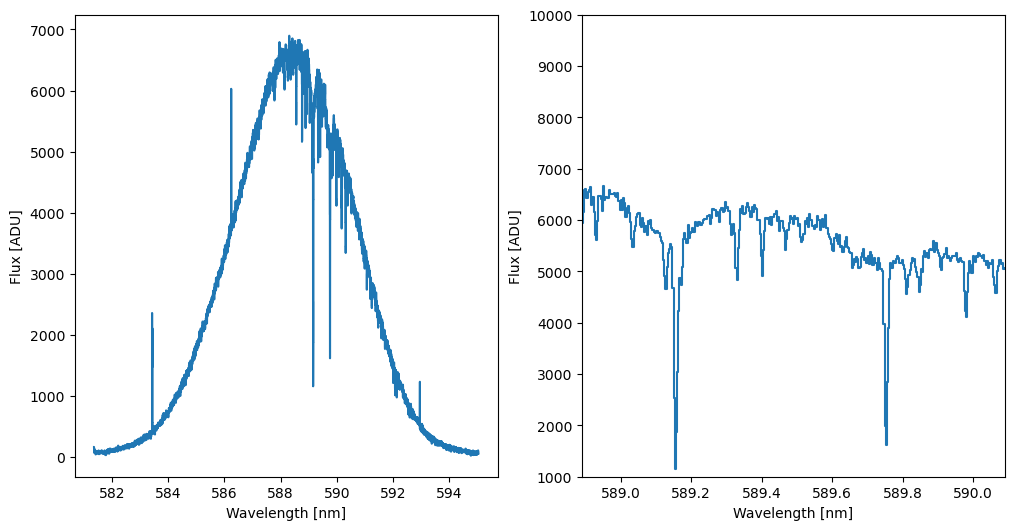

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].step(spectrum['wave'][1], spectrum['flux'][1], where='mid')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Flux [ADU]')
ax[1].step(spectrum['wave'][1], spectrum['flux'][1], where='mid')
plt.xlim(588.89, 590.09)
plt.ylim(1000, 10000)
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Flux [ADU]')